WebSSL
====

**Scaling Language-Free Visual Representation Learning**

 * Paper: https://arxiv.org/abs/2504.01017

![WebSSL Improvements](../assets/webssl_overview.png)

```bash
pip install torch torchvision
pip install transformers
```

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import AutoImageProcessor, Dinov2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoImageProcessor.from_pretrained(
    "facebook/webssl-dino1b-full2b-224",
    use_fast=True
)
# 'eager' and 'sdpa' attn_implementation supported
model = Dinov2Model.from_pretrained(
    "facebook/webssl-dino1b-full2b-224"
).eval().to(device);

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


In [5]:
# Process an image
image = Image.open('../samples/plants.jpg').convert('RGB')
inputs = processor(images=image, return_tensors="pt")
inputs = inputs.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

cls_features = outputs.last_hidden_state[:, 0]  # CLS token features
patch_features = outputs.last_hidden_state[:, 1:] # patch-wise token features

print(cls_features.shape)  # (batch_size, hidden_size)
print(patch_features.shape)  # (batch_size, num_patches, hidden_size)

torch.Size([1, 1536])
torch.Size([1, 256, 1536])


### Image similarity

In [38]:
anchor_paths = [
    f for f in os.listdir("../samples/")
    if f.startswith('anchor_') and f.endswith('.jpg')
]

sample_paths = [
    f for f in os.listdir("../samples/")
    if f.endswith('.jpg') and not f.startswith('anchor_')
]
print(anchor_paths)
print(sample_paths)

['anchor_fruits.jpg', 'anchor_sealion.jpg', 'anchor_person.jpg', 'anchor_house.jpg', 'anchor_bicycle.jpg', 'anchor_plant.jpg']
['plants.jpg', 'bicycle.jpg', 'bicycle-02.jpg', 'person.jpg', 'sealions-sf.jpg', 'house.jpg', 'fruits-02.jpg', 'fruits-01.jpg']


In [39]:
anchor_imgs = [
    Image.open(os.path.join("../samples/", f)).convert("RGB")
    for f in anchor_paths
]

sample_imgs = [
    Image.open(os.path.join("../samples/", f)).convert("RGB")
    for f in sample_paths
]

anchor_inputs = processor(
    images=anchor_imgs,
    return_tensors="pt",
    padding=True,
    truncation=True
)
anchor_inputs = anchor_inputs.to(device)

sample_inputs = processor(
    images=sample_imgs,
    return_tensors="pt",
    padding=True,
    truncation=True
)
sample_inputs = sample_inputs.to(device)

# Forward pass
with torch.no_grad():
    anchor_outputs = model(**anchor_inputs)
    sample_outputs = model(**sample_inputs)
anchor_features = anchor_outputs.last_hidden_state[:, 0]
sample_features = sample_outputs.last_hidden_state[:, 0]
print(anchor_features.shape)
print(sample_features.shape)

torch.Size([6, 1536])
torch.Size([8, 1536])


In [ ]:
# normalize features
anchor_features_norm = torch.nn.functional.normalize(
    anchor_features, dim=1
)
sample_features_norm = torch.nn.functional.normalize(
    sample_features, dim=1
)

# compute cosine similarity
similarity_matrix = sample_features_norm @ anchor_features_norm.T
print(similarity_matrix.shape)

torch.Size([8, 6])


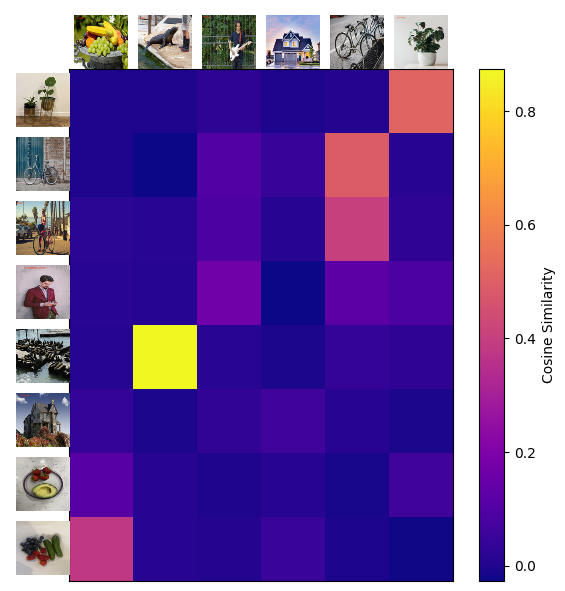

In [80]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def add_image_ticks(axis, images, xycoords, direction='x'):
    for idx, img in enumerate(images):
        imagebox = OffsetImage(img, zoom=0.3)
        if direction == 'x':
            ab = AnnotationBbox(
                imagebox, (idx, -0.5),
                xycoords=xycoords, frameon=False,
                box_alignment=(0.5, 0)
            )
        else:
            ab = AnnotationBbox(
                imagebox, (-0.5, idx),
                xycoords=xycoords, frameon=False,
                box_alignment=(1, 0.5)
            )
        axis.add_artist(ab)


standard_size = (128, 128)

def resize_image(image, size):
    return image.resize(size)

anchor_imgs_resized = [
    resize_image(img, standard_size) for img in anchor_imgs
]
sample_imgs_resized = [
    resize_image(img, standard_size) for img in sample_imgs
]

similarity_matrix_np = similarity_matrix.cpu().numpy()

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(top=0.75, left=0.25)

plt.imshow(similarity_matrix_np, cmap='plasma')
plt.colorbar(label='Cosine Similarity')

add_image_ticks(
    ax, anchor_imgs_resized,
    xycoords='data', direction='x'
)
add_image_ticks(
    ax, sample_imgs_resized,
    xycoords='data', direction='y'
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()